<a href="https://colab.research.google.com/github/Joefamouze/image_captioning/blob/main/Image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning with Visual Attention

Image captioning models take an image as input, and output text. Ideally, I want the output of the model to accurately describe the events/things in the image, similar to a caption a human might provide.

In order to generate text, I will build an encoder-decoder model, where the encoder output embedding of an input image, and the decoder output text from the image embedding

I this notebook, I will use the model architecture similar to Show, Attend and Tell: Neural Image Caption Generation with Visual Attention, and build Attention-based image captioning model.

This notebook is an end-to-end example. The training dataset is the COCO large-scale object detection, segmentation, and captioning dataset.



In [1]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

print(tf.version.VERSION)

2.15.0


# Preparing pretrained model for transfer learning

The InceptionResNetV2 will be used for this purpose. We extract the features from the model. This CNN backbone extracts a "thought vector" from input images



In [2]:
# Change these to control the accuracy/speed
VOCAB_SIZE = 20000  # use fewer words to speed up convergence
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128

# InceptionResNetV2 takes (299, 299, 3) image as inputs
# and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

219055592/219055592 [==============================] - 1s 0us/step


# Filter and Preprocess
Here we preprocess the dataset. The function below:

resize image to (IMG_HEIGHT, IMG_WIDTH) shape
rescale pixel values from [0, 255] to [0, 1]
return image(image_tensor) and captions(captions) dictionary.
Note: This dataset is too large to store in an local environment. Therefore, It is stored in a public GCS bucket located in us-central1. So if you access it from a Notebook outside the US, it will be (a) slow and (b) subject to a network charge.

In [7]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000


def get_image_label(example):
    caption = example["captions"]["text"][0]  # only the first caption per image
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "caption": caption}


trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

trainds = trainds.map(
    get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

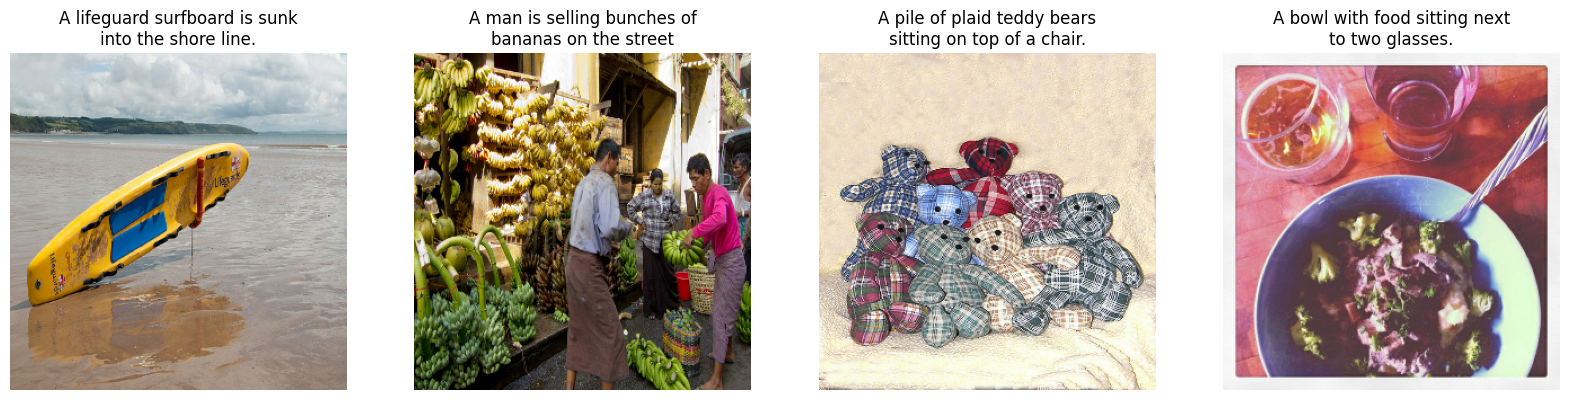

In [8]:
#visualize

f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

# Text Preprocessing
We add special tokens to represent the starts (<start>) and the ends (<end>) of sentences.
Start and end tokens are added here because we are using an encoder-decoder model and during prediction, to get the captioning started we use <start> and since captions are of variable length, we terminate the prediction when we see the <end> token.

Then create a full list of the captions for further preprocessing.

In [9]:
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start>")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join(
        [start, data["caption"], end], separator=" "
    )
    return data


trainds = trainds.map(add_start_end_token)

# Preprocess and tokenize the captions
Here we transform the text captions into integer sequences using the TextVectorization layer, with the following steps:

Use adapt to iterate over all captions, split the captions into words, and compute a vocabulary of the top VOCAB_SIZE words.
Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to the length MAX_CAPTION_LEN. Here we directly specify 64 number which is sufficient for this dataset.


In [10]:
MAX_CAPTION_LEN = 64


# override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))


In [15]:
#sampling the tokenizer

tokenizer(["<start> What does platitude mean? <end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[   3, 1025,  920,    1, 2661,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [16]:
sample_captions = []
for d in trainds.take(5):
    sample_captions.append(d["caption"].numpy())


In [17]:
sample_captions

[b'<start> The room is filled with remarkable items well suited.\n <end>',
 b'<start> two people near a giraffe near many trees <end>',
 b'<start> A bench in front of flowers at night <end>',
 b'<start> A man standing next to another man in a wheel chair. <end>',
 b'<start> A colorful Christmas tree sitting next to couches in a living room. <end>']

In [18]:
for word_id in tokenizer([sample_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[word_id], end=" ")

<start> the room is filled with remarkable items well suited <end>                                                      

In [19]:
# Lookup table: Word -> Index
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)